# 部分空間法とは

部分空間法は，クラス毎にデータ分布を近似した辞書部分空間Qと入力データxとの類似度に基づく識別手法である．部分空間法を拡張した相互部分空間法は，辞書部分空間Qと入力部分空間Pを比較することで識別を行う手法です．

![](Screenshot_2019-12-11-201613087.png)


ここで，辞書部分空間や入力部分空間といった複雑そうなワードが登場しているが，自称部分空間は学習データをもとに作成した部分空間のことを指しており，入力部分空間は入力ベクトルをもとに作成した部分空間を指しているだけです．他にも，形状部分空間や異常部分空間など，様々なネーミングがあるが，なにをもとにした部分空間かを指しているだけの場合が多く，そんなに複雑なことではありません．安心してください（笑）．

## そもそも部分空間とは

> 部分空間とは、あるベクトル空間Vの部分集合Wで、ベクトル空間となっているもののことをいいます。[※](http://senkei.nomaki.jp/subspace.html)

Wがベクトル空間になっているかどうかを調べるには以下の3つの条件だけ調べればOKです.
![](Screenshot_2019-12-11\%20部分空間とは.png)

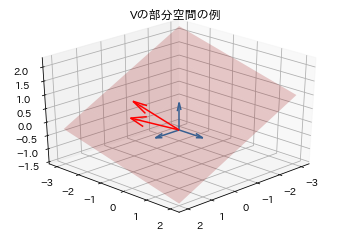

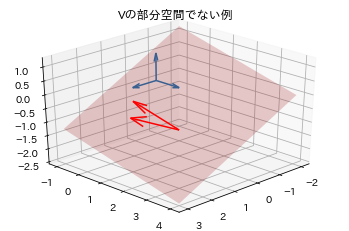

In [2]:
%matplotlib inline

import japanize_matplotlib
import numpy as np, sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
    
def plot_3dspace(origin =[0,0,0]):
    V = np.matrix([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    origin = [0,0,0]
    ax.quiver(*origin, V[:, 0], V[:, 1], V[:, 2])
    return fig ,ax

def plot_2dspan(W, origin =[0,0,0], ax=None):
    if ax == None:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    normal = np.cross(W[0], W[1])[0]
    d = -W[0].dot(normal.T)  
    x, y = np.meshgrid(range(-3,3), range(-3,3))
    z = (normal[0]*x - normal[1]*y) / normal[2]   
    ax.quiver(*origin, W[:, 0], W[:, 1], W[:, 2], color='red')
    ax.plot_surface(x+origin[0],y+origin[1],z+origin[2], alpha=0.2, color='red')
    ax.view_init(azim=45, elev=30)

fig,ax = plot_3dspace()
ax.set_title('Vの部分空間の例')
P = np.matrix([
        [2,0,1],
        [0,-2,0.5]
    ])
plot_2dspan(P, ax=ax)
plt.show()

# Pをｄだけ平行移動させる
fig,ax = plot_3dspace()
d = np.array([1,2,-1])
plot_2dspan(P, d, ax=ax)
ax.set_title('Vの部分空間でない例')
plt.show()

原点を通る２つのベクトルがつくる部分空間は必ず部分空間なので，上記の「部分空間でない例」ではわざわざ平行移動をさせましたが，このような空間はアフィン空間と呼ばれます．

>"An affine space is a vector space that's forgotten its origin" 「アフィン空間とは原点を忘れてしまったベクトル空間のことである」[※](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%95%E3%82%A3%E3%83%B3%E7%A9%BA%E9%96%93)

なんて言われるぐらいですが．ちゃんとした説明は※を辿ってください．

## 部分空間を使った識別 with Mnist

ここで単純な部分空間法の識別性能を示すためにMNISTのデータを使った識別を行います．まずはK-NNでベースラインとなる精度を示し，そのあとに部分空間を使った手法を使用した結果で比較をします．

In [78]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=500, test_size=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

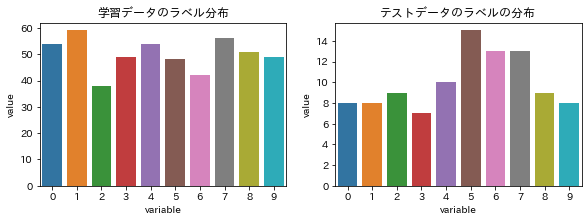

In [79]:
from collections import Counter
from pandas import DataFrame as DF
import seaborn as sns
from scipy.constants import golden as g

fig = plt.figure(figsize=(6*g, 3))

sns.barplot(x="variable", y="value", data=DF(Counter(y_train),index=['val']).melt(), ax=fig.add_subplot(121))
plt.title("学習データのラベル分布")

sns.barplot(x="variable", y="value", data=DF(Counter(y_test),index=['val']).melt(), ax= fig.add_subplot(122))
plt.title("テストデータのラベルの分布")
plt.show()

## K-NN with Euclidean Distance

In [91]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

def plot_score(model, x_train, y_train, x_test, y_test, title='', k=range(5)):
    scores = np.zeros(len(k)) 
    for i,j in enumerate(k):
        clf = model(n_neighbors=j)
        clf.fit(x_train, y_train)
        scores[i] = accuracy_score(y_test, clf.predict(x_test))
    
    plt.plot(k, scores)
    plt.title(f'{title}: {max(scores):.2%}@K={k[np.argmax(scores)]}')
    plt.ylabel('Accuracy')
    plt.xlabel('k')
    plt.show()

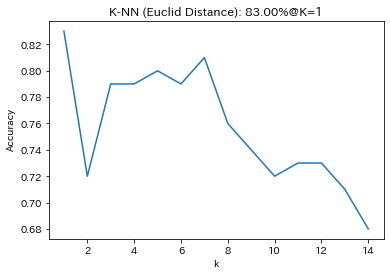

In [92]:
euclidKNN = neighbors.KNeighborsClassifier
plot_score(euclidKNN, X_train, y_train, X_test, y_test, title='K-NN (Euclid Distance)', k=range(1,15))

## Subpace Method (KNN with cosine with PCA)

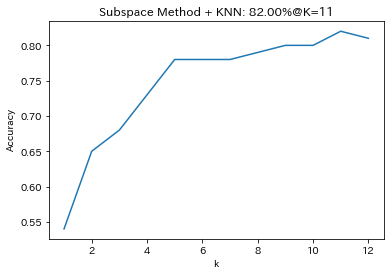

In [146]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class subspace_classifier:
    def __init__(self, n_neighbors):
        subspace_dict = {}
        self.n_neighbors = n_neighbors
        self.subspace_dict = subspace_dict
        
    def fit(self, x_train, y_test,mode='pca'):
        for y in np.unique(y_test):
            x = x_train[np.where(y_test==y)]
            if mode=='pca': pca = PCA(n_components=None)
            elif mode=='kpca': pca = KernelPCA(n_components=7, kernel='linear')
                
            scaler = StandardScaler().fit(x)
            x = scaler.transform(x)
#             x = (x - x.mean())/x.std()
            principalComponents = pca.fit(x)
            self.subspace_dict[y] = {
                'subspace':principalComponents.components_,
                'mean': x.mean(),
                'std':x.std()
            }
        return self

    def similarity(self, vec, mat):
        # distance function = cosine distance
        cos_dist = lambda x: np.power(vec.T @ x, 2) / np.linalg.norm(vec) * np.linalg.norm(x)
        S = np.apply_along_axis(func1d=cos_dist, arr=mat, axis=1)
        return np.sum(sorted(S, reverse=True)[:self.n_neighbors])
#         return np.max(S)
        
    def predict(self, x_test):
        pred_lst = []
        for x in x_test:
            pred = (None, 0) 
            for label, d in self.subspace_dict.items():
#                 scaler = d['scaler']
#                 S = self.similarity(scaler.transform(x.reshape(1,-1))[0], subspace)
#                 S = self.similarity((x-d['mean'])/d['std'], d['subspace'])
                S = self.similarity(x, d['subspace'])
                pred = (label, S) if S >= pred[1] else pred
            pred_lst.append(pred[0])
        return pred_lst
    
SMKNN = subspace_classifier
plot_score(SMKNN, X_train, y_train, X_test, y_test, title='Subspace Method + KNN', k=range(1, 13))

/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


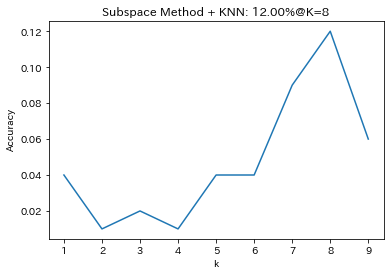

In [125]:
clf = LinearDiscriminantAnalysis(n_components=500)
# pca = PCA(n_components=300).fit(X_train)
# X_train_lda = clf.fit_transform(pca.transform(X_train), y_train)
# X_test_lda = clf.transform(pca.transform(X_test))
X_train_lda = clf.fit_transform(X_train, y_train)
X_test_lda = clf.transform(X_test)
plot_score(SMKNN, X_train_lda, y_train, X_test_lda, y_test, title='Subspace Method + KNN', k=range(1,10))

In [ ]:
vec = np.array([[13,1325,13261,32451265,1234],[13,1325,13261,32451265,1234]])
x = np.array([13,1325,13261,32451265,1234])

np.inner(vec,x)**2 / np.linalg.norm(vec) * np.linalg.norm(x)

## なぜ識別性能が向上したのか？

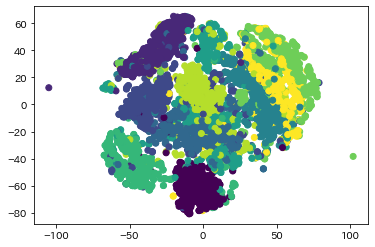

In [5]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(X_train)
plt.scatter(*X_embedded.T, c=list(map(int,y_train)))
plt.show()

In [71]:
X_train.mean()

1.4464619977973469e-18

In [53]:
4*[g, 1]

[1.618033988749895,
 1,
 1.618033988749895,
 1,
 1.618033988749895,
 1,
 1.618033988749895,
 1]